In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# Function to read ChromHMM output and categorize states
def read_chromhmm(directory, file_name):
    with open(directory + file_name) as f:
        jets = {}
        for line in f:
            tmp_list = [0,0,0,0,0,0,0] # prom, enh, txn, ins, rep, het, other
            tmp = line.strip().split("\t")
            region = tmp[0]+":"+tmp[1]+"-"+tmp[2]
            stateid = tmp[3].split("_")[0]
            length = int(tmp[4])
            if stateid in ['1', '2', '3']: #prom
                state = 0
            elif stateid in ['4', '5', '6', '7']: #enh
                state = 1
            elif stateid in ['9', '10', '11']: #txn
                state = 2
            elif stateid == '8': #insulator
                state = 3
            elif stateid == '12': # repressed
                state = 4
            elif stateid == '13': # het
                state = 5
            else: # other
                state = 6
            if region not in jets.keys():
                jets[region] = tmp_list
            jets[region][state] += length
    return jets

In [3]:
# Function to get summary statistics from the categorized states
def get_summ_stat(jetdict):
    tmpstate = []
    sumlength = [0, 0, 0, 0, 0, 0, 0]
    idx2state = {"0":"prom", "1":"enh", "2":"txn", "3":"ins", "4":"rep", "5":"het", "6":"other"}
    for k,v in jetdict.items():
        totlen = sum(v)
        if totlen > 0:
            if v[1] > 0 and v[1]/totlen > 0.2:
                state = 'enh'
            elif max(v)/totlen > 0.3:
                #print(str(v.index(max(v))))
                state = idx2state[str(v.index(max(v)))]
            else:
                state = "other"
        else:
            state = "other"
        tmpstate.append(state)
        for i in range(7):
            sumlength[i] += v[i]
    print(Counter(tmpstate))
    print(sumlength)
    print(sum(sumlength))
    print([round(i/sum(sumlength)*100, 2) for i in sumlength])
    #return tmpvals

### Summary Statistics for GM12878 CTCF ChIP-seq and CUTRUN Chrom-Sig and Original

In [4]:
directory='/nfs/turbo/umms-minjilab/zapell/chrom-sig/chromHMM_annotation/'
chip_seq_GM12878_raw='GM12878_ChIP-seq_CTCF_ENCFF355CYX_raw_SICER_chromhmmanno.bed'
chip_seq_GM12878_chromsig='GM12878_ChIP-seq_CTCF_ENCFF355CYX_chrom-sig_FDR0.1_pseudoRead5000_SICER_chromhmmanno.bed'
cutrun_GM12878_raw='GM12878_CUTRUN_CTCF_4DNFI2G71DR4_raw_SICER_chromhmmanno.bed'
cutrun_GM12878_chromsig='GM12878_CUTRUN_CTCF_4DNFI2G71DR4_chrom-sig_FDR0.1_pseudoRead_5000_SICER_chromhmmanno.bed'
chip_seq_HCT116_raw='HCT116_ChIP-seq_CTCF_ENCFF172XLC_raw_SICER_chromhmmanno.bed'
chip_seq_HCT116_chromsig='HCT116_ChIP-seq_CTCF_ENCFF172XLC_chrom-sig_FDR0.1_pseudoRead_5000_SICER_chromhmmanno.bed'

In [5]:
GM12878_chip_raw = read_chromhmm(directory, chip_seq_GM12878_raw)
GM12878_chip_chromsig = read_chromhmm(directory, chip_seq_GM12878_chromsig)
GM12878_cutrun_raw = read_chromhmm(directory, cutrun_GM12878_raw)
GM12878_cutrun_chromsig = read_chromhmm(directory, cutrun_GM12878_chromsig)
HCT116_raw = read_chromhmm(directory, chip_seq_HCT116_raw)
HCT116_chromsig = read_chromhmm(directory, chip_seq_HCT116_chromsig)

In [6]:
get_summ_stat(GM12878_chip_raw)

Counter({'ins': 9419, 'het': 8220, 'enh': 8177, 'prom': 4672, 'txn': 4284, 'rep': 1283, 'other': 214})
[11910038, 10076024, 8542848, 11965988, 2511225, 13295660, 123922]
58425705
[20.38, 17.25, 14.62, 20.48, 4.3, 22.76, 0.21]


In [7]:
get_summ_stat(GM12878_chip_chromsig)

Counter({'ins': 15544, 'enh': 4204, 'prom': 3255, 'txn': 1344, 'het': 239, 'other': 189, 'rep': 97})
[1895719, 1483807, 722786, 6427225, 86017, 463584, 22046]
11101184
[17.08, 13.37, 6.51, 57.9, 0.77, 4.18, 0.2]


In [8]:
get_summ_stat(GM12878_cutrun_raw)

Counter({'enh': 23829, 'het': 13096, 'prom': 6780, 'txn': 4884, 'ins': 4259, 'rep': 1367, 'other': 1036})
[19497814, 33383275, 14639428, 10959163, 3410183, 27471312, 559704]
109920879
[17.74, 30.37, 13.32, 9.97, 3.1, 24.99, 0.51]


In [9]:
get_summ_stat(GM12878_cutrun_chromsig)

Counter({'ins': 8877, 'enh': 4266, 'prom': 2092, 'txn': 812, 'het': 477, 'other': 199, 'rep': 51})
[1754648, 1924455, 700218, 4358482, 100046, 792779, 51240]
9681868
[18.12, 19.88, 7.23, 45.02, 1.03, 8.19, 0.53]


In [10]:
# function to plot barplot of chromHMM state percentages
def plot_annotations(raw_dict, chromsig_dict, labels=None, cell_line='GM12878', exp_type='ChIP-seq', sample_id='', outfile='chromhmm_state_barplot.jpg'):
    # Get percentages for each state from summary statistics
    def get_percentages(jetdict):
        sumlength = [0, 0, 0, 0, 0, 0, 0]
        for v in jetdict.values():
            for i in range(7):
                sumlength[i] += v[i]
        total = sum(sumlength)
        return [round(i/total*100, 2) if total > 0 else 0 for i in sumlength]

    idx2state = ["Promoter", "Enhancer", "Transcription", "Insulator", "Repressed Polycomb", "Heterochromatin", "Other"]
    raw_pct = get_percentages(raw_dict)
    chromsig_pct = get_percentages(chromsig_dict)

    if labels is None:
        labels = idx2state

    data = np.array([chromsig_pct, raw_pct])
    categories = labels
    samples = ['Chrom-Sig', 'Original']
    colors = ["Red", "Orange", "Green", "Blue", "Gray", "lightgray", "whitesmoke"] 

    fig, ax = plt.subplots(figsize=(12, 5))
    left = np.zeros(2)
    for i, cat in enumerate(categories):
        bars = ax.barh(samples, data[:, i], left=left, color=colors[i], label=cat, alpha=0.4)
        # Add percentage annotation to each segment
        for j, bar in enumerate(bars):
            width = bar.get_width()
            #if width > 4:  # Only annotate if segment is visible
            #    ax.text(left[j] + width/2, bar.get_y() + bar.get_height()/2,
            #            f"{width:.1f}%", va='center', ha='center', fontsize=12, color='black')
        left += data[:, i]

    ax.set_xlabel('Percentage', fontsize=14)
    ax.tick_params(axis='y', labelsize=14, labelrotation=90)
    
    ax.set_yticks(np.arange(len(samples)))
    ax.set_yticklabels(samples)
    #ax.set_yticklabels(ax.get_yticklabels(), rotation=90)  # Rotate y-tick labels
    ax.set_title(f'{cell_line} {exp_type} {sample_id} ChromHMM State Percentages', fontsize=16, fontweight='bold')
    ax.legend(
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        fontsize=12,
        handleheight=4,  # increase for taller boxes
        handlelength=5,    # increase for wider boxes
        frameon=True
    )
    plt.tight_layout()
    plt.savefig(outfile)
    plt.show()

## Plots

### GM12878 CTCF CUTRUN & ChIP-seq

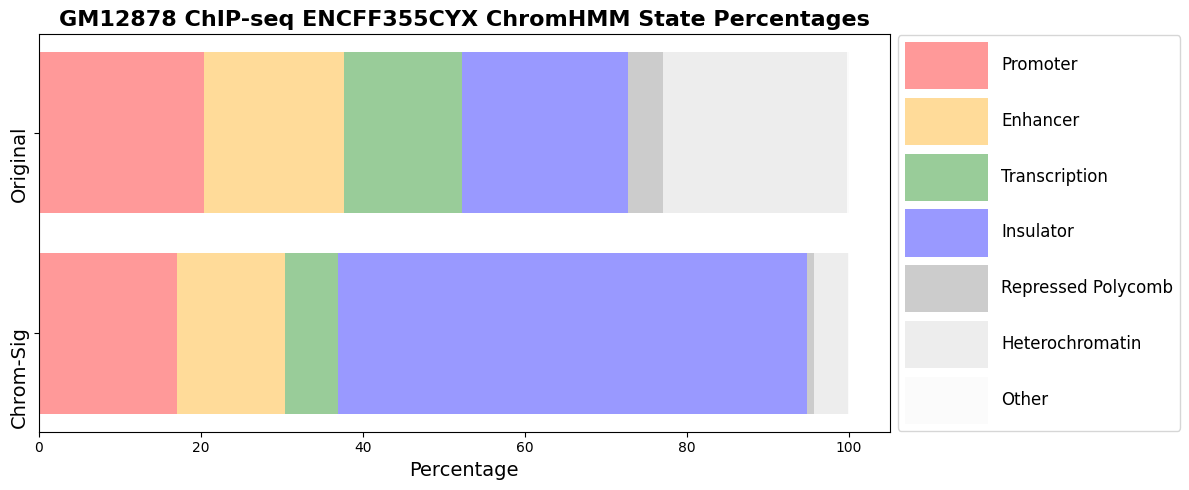

In [11]:
outdir='/nfs/turbo/umms-minjilab/zapell/chrom-sig/plots/chromHMM/'
plot_annotations(GM12878_chip_raw, GM12878_chip_chromsig, cell_line='GM12878', exp_type='ChIP-seq', sample_id='ENCFF355CYX' ,outfile=outdir+'GM12878_chip_seqchromhmm_state_barplot.jpg')

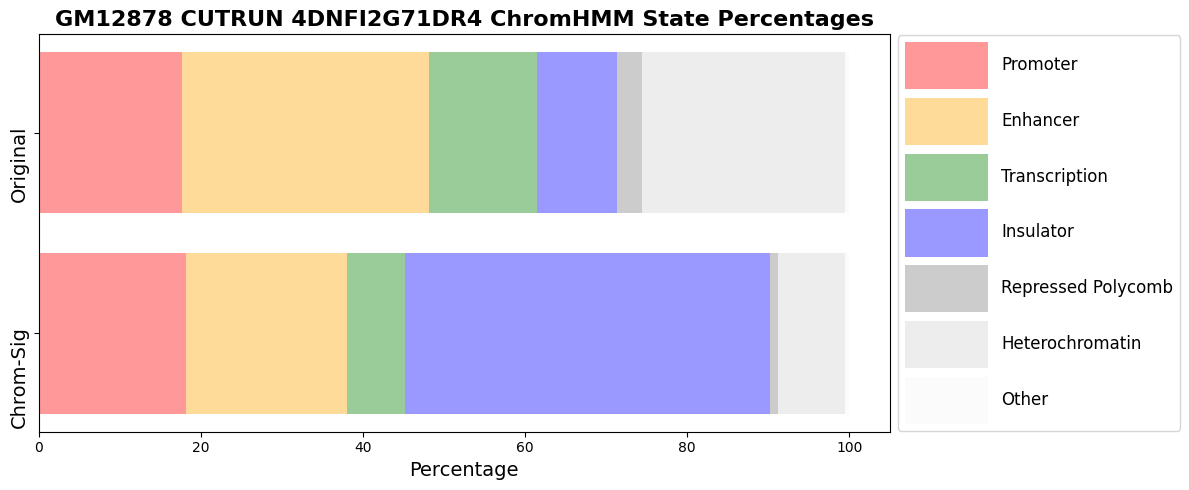

In [12]:
plot_annotations(GM12878_cutrun_raw, GM12878_cutrun_chromsig,cell_line='GM12878', exp_type='CUTRUN', sample_id='4DNFI2G71DR4' ,outfile=outdir+'GM12878_cutrun_chromhmm_state_barplot.jpg')

### GM12878 ATAC-seq

In [24]:
GM12878_ATAC_raw='GM12878_ATAC_ENCFF646NWY_raw_SICER.bedgraph_chromhmmanno.bed'
GM12878_ATAC_chromsig='GM12878_ATAC_ENCFF646NWY_chrom-sig_FDR0.1_pseudoRead5000_SICER.bedgraph_chromhmmanno.bed'

GM12878_ATAC_raw_data = read_chromhmm(directory, GM12878_ATAC_raw)
GM12878_ATAC_chromsig_data = read_chromhmm(directory, GM12878_ATAC_chromsig)

In [19]:
get_summ_stat(GM12878_ATAC_chromsig_data)

Counter({'enh': 44241, 'prom': 11273, 'ins': 9421, 'het': 8008, 'txn': 4212, 'rep': 952, 'other': 400})
[32042088, 54072370, 5999729, 5636911, 1149235, 7423451, 107102]
106430886
[30.11, 50.81, 5.64, 5.3, 1.08, 6.97, 0.1]


In [20]:
get_summ_stat(GM12878_ATAC_raw_data)

Counter({'enh': 44236, 'het': 10512, 'prom': 8289, 'txn': 6841, 'ins': 6393, 'rep': 1681, 'other': 399})
[40480452, 85255239, 33771792, 6770622, 4551517, 21974969, 201539]
193006130
[20.97, 44.17, 17.5, 3.51, 2.36, 11.39, 0.1]


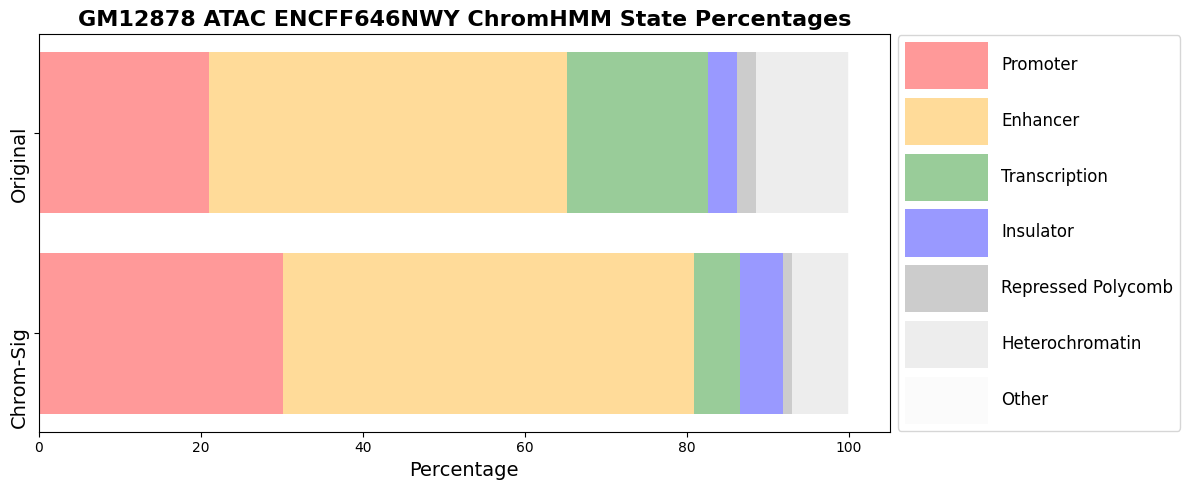

In [21]:
plot_annotations(GM12878_ATAC_raw_data, GM12878_ATAC_chromsig_data,cell_line='GM12878', exp_type='ATAC', sample_id='ENCFF646NWY' ,outfile=outdir+'GM12878_ATAC_chromhmm_state_barplot.jpg')

### K562 POLR2A ChIP-seq

In [ ]:
K562_POL_ENCFF480AJZ_raw='K562_ChIP_seq_POLR2A_ENCFF480AJZ_raw_SICER.bedgraph_chromhmmanno.bed'
K562_POL_ENCFF480AJZ_chromsig='K562_ChIP_seq_POLR2A_ENCFF480AJZ_chrom-sig_FDR0.1_pseudoRead5000_SICER.bedgraph_chromhmmanno.bed'
K562_POL_ENCFF785OCU_raw='K562_ChIP_seq_POLR2A_ENCFF785OCU_raw_SICER.bedgraph_chromhmmanno.bed'
K562_POL_ENCFF785OCU_chromsig='K562_ChIP_seq_POLR2A_ENCFF785OCU_chrom-sig_FDR0.1_pseudoRead5000_SICER.bedgraph_chromhmmanno.bed'



In [ ]:
K562_POL_ENCFF480AJZ_raw_data = read_chromhmm(directory, K562_POL_ENCFF480AJZ_raw)
K562_POL_ENCFF480AJZ_chromsig_data = read_chromhmm(directory, K562_POL_ENCFF480AJZ_chromsig)
K562_POL_ENCFF785OCU_raw_data = read_chromhmm(directory, K562_POL_ENCFF785OCU_raw)
K562_POL_ENCFF785OCU_chromsig_data = read_chromhmm(directory, K562_POL_ENCFF785OCU_chromsig)


In [15]:
get_summ_stat(K562_POL_ENCFF480AJZ_raw_data)

Counter({'enh': 23995, 'txn': 11039, 'other': 4086, 'het': 2451, 'prom': 1944, 'rep': 141, 'ins': 18})
[8255724, 24625905, 7043049, 41740, 168275, 1615040, 969220]
42718953
[19.33, 57.65, 16.49, 0.1, 0.39, 3.78, 2.27]


In [16]:
get_summ_stat(K562_POL_ENCFF480AJZ_chromsig_data)

Counter({'enh': 13581, 'other': 6793, 'prom': 4575, 'txn': 3742, 'het': 602, 'rep': 42, 'ins': 31})
[4861038, 6480635, 1043613, 6370, 19177, 250145, 322665]
12983643
[37.44, 49.91, 8.04, 0.05, 0.15, 1.93, 2.49]


In [17]:
get_summ_stat(K562_POL_ENCFF785OCU_raw_data)

Counter({'enh': 23383, 'txn': 9684, 'other': 2679, 'het': 2552, 'prom': 1808, 'rep': 141, 'ins': 14})
[8545074, 26154705, 7513524, 45460, 152781, 1731170, 949130]
45091844
[18.95, 58.0, 16.66, 0.1, 0.34, 3.84, 2.1]


In [18]:
get_summ_stat(K562_POL_ENCFF785OCU_chromsig_data)

Counter({'enh': 15839, 'other': 8574, 'txn': 5243, 'prom': 4489, 'het': 949, 'rep': 77, 'ins': 67})
[5317455, 7970010, 1486395, 9140, 27813, 373625, 347900]
15532338
[34.23, 51.31, 9.57, 0.06, 0.18, 2.41, 2.24]


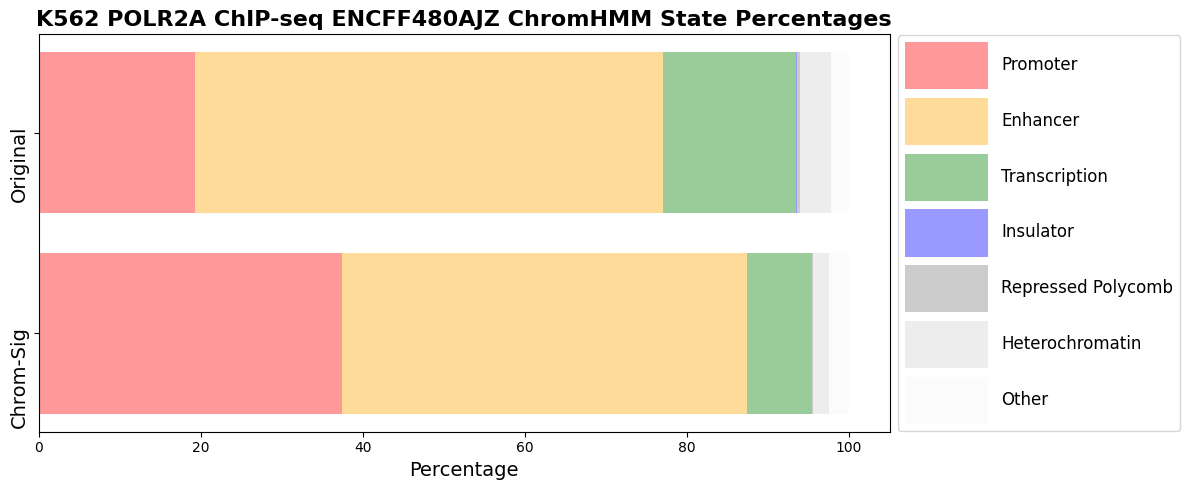

In [22]:
plot_annotations(K562_POL_ENCFF480AJZ_raw_data, K562_POL_ENCFF480AJZ_chromsig_data,cell_line='K562', exp_type='POLR2A ChIP-seq', sample_id='ENCFF480AJZ' ,outfile=outdir+'K562_POL_ENCFF480AJZ_chromhmm_state_barplot.jpg')

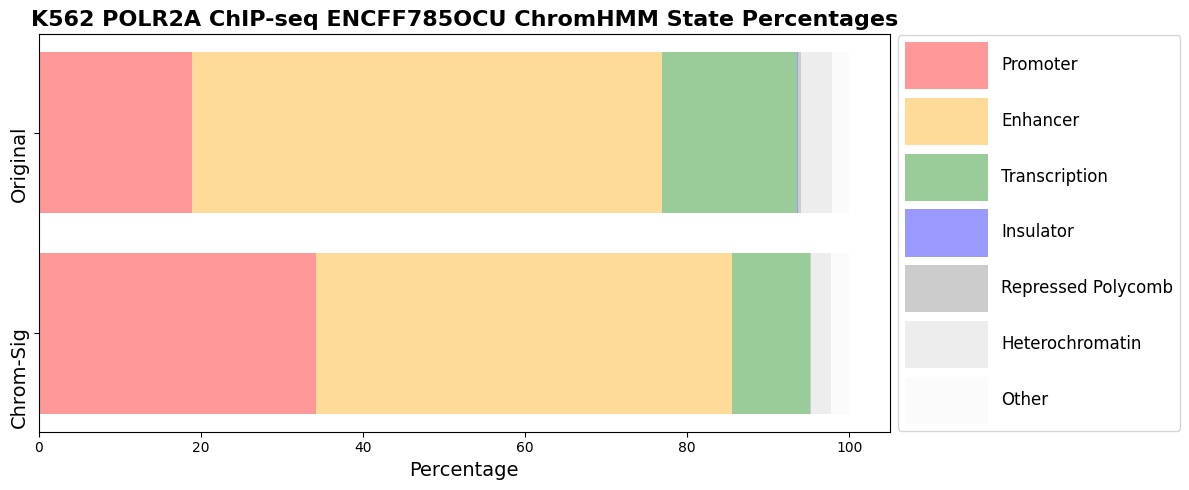

In [23]:
plot_annotations(K562_POL_ENCFF785OCU_raw_data, K562_POL_ENCFF785OCU_chromsig_data,cell_line='K562', exp_type='POLR2A ChIP-seq', sample_id='ENCFF785OCU' ,outfile=outdir+'K562_POL_ENCFF785OCU_chromhmm_state_barplot.jpg')